In [1]:
import pandas as pd
from fbprophet import Prophet
from DatenSammlung import DatenVergangenheitHolen, FeiertageHolen, WetterVorhersageNBG
from DatenVerarbeitung import DatenVerarbeitung

Importing plotly failed. Interactive plots will not work.
Today's date: 2021-04-01
Today's date: 2021-04-01


In [5]:
df = DatenVerarbeitung()

start_date and end_date filtering limited to defined periods [<Period.HISTORICAL: 'historical'>, <Period.RECENT: 'recent'>, <Period.NOW: 'now'>]
The combination of kl, daily, now is invalid.
100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#In die Funktion Datenverarbeitung integrieren...todo
feiertage = FeiertageHolen()
feiertage.loc[:,'Date'] = pd.to_datetime(feiertage['Date'])
feiertage = feiertage.set_index('Date')
feiertage['Feiertag'] = 1

In [7]:
df_test = df


In [9]:
df_test.head()

,7TIW,Temperatur,ResNbg
Date,,,
2020-04-02,33.204633,4.7,76.85
2020-04-03,36.872587,5.7,76.85
2020-04-04,36.293436,8.0,76.85
2020-04-05,35.328185,10.9,76.85
2020-04-06,36.486486,10.9,76.85


In [10]:
df_test = df_test.join(feiertage)
df_test = df_test.fillna(0)

In [72]:
#df_test.loc['2021-01-01']

7TIW          285.714286
Temperatur      1.700000
ResNbg         82.410000
Feiertag        1.000000
Name: 2021-01-01 00:00:00, dtype: float64

In [11]:
df_test.head()

,7TIW,Temperatur,ResNbg,Feiertag
Date,,,,
2020-04-02,33.204633,4.7,76.85,0.0
2020-04-03,36.872587,5.7,76.85,0.0
2020-04-04,36.293436,8.0,76.85,0.0
2020-04-05,35.328185,10.9,76.85,0.0
2020-04-06,36.486486,10.9,76.85,0.0


In [11]:
#df_resampled = df_test.resample('W', label='right').sum()
#df_resampled = df_resampled.reset_index()

In [35]:
#df_test['month'] = df_test.Date.dt.month
#df_test['day'] = df_test.Date.dt.day
#df_test['day_of_year'] = df_test.Date.dt.dayofyear
#df_test['week_of_year'] = df_test.Date.dt.weekofyear

ipykernel_launcher:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


<AxesSubplot:xlabel='Date'>

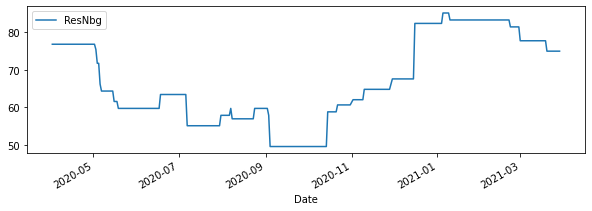

In [23]:
df_test.plot(x='Date',y='ResNbg',figsize=(10,3))

In [17]:
df_test

,7TIW,Temperatur,ResNbg,Feiertag
Date,,,,
2020-04-02,33.204633,4.7,76.85,0.0
2020-04-03,36.872587,5.7,76.85,0.0
2020-04-04,36.293436,8.0,76.85,0.0
2020-04-05,35.328185,10.9,76.85,0.0
2020-04-06,36.486486,10.9,76.85,0.0
...,...,...,...,...
2021-03-27,189.961390,7.9,75.00,0.0
2021-03-28,186.100386,8.3,75.00,0.0
2021-03-29,190.733591,10.5,75.00,0.0


In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [230]:
df_test['date'] = df_test.index

In [239]:
trainings_zeitraum_von = '2020-11-01'
df_test = df_test.loc[df_test.index>trainings_zeitraum_von].copy()

In [240]:
split_date = '2021-3-25'
dftrain = df_test.loc[df_test.index <= split_date].copy()
dftest = df_test.loc[df_test.index > split_date].copy()

In [241]:
X_train = dftrain[['Temperatur','ResNbg','Feiertag']]
y_train = dftrain[['7TIW']]

X_test = dftest[['Temperatur','ResNbg','Feiertag']]
y_test = dftest[['7TIW']]

# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        return grad, hess
    return _log_cosh_quantile

alpha = 0.55

model = xgb.XGBRegressor(objective=log_cosh_quantile(alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)
model.fit(X_train, y_train)

upper_pred = model.predict(X_test)

model = xgb.XGBRegressor(objective=log_cosh_quantile(1-alpha),
                       n_estimators=125,
                       max_depth=5,
                       n_jobs=6,
                       learning_rate=.05)
model.fit(X_train, y_train)

lower_pred = model.predict(X_test)

X_test['Prediction_upper'] = upper_pred
X_test['Prediction_lower'] = lower_pred

In [242]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

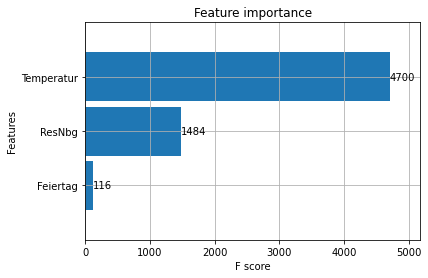

In [243]:
_ = plot_importance(reg, height=0.9)

In [244]:
X_test['Prediction'] = reg.predict(X_test)


ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [245]:
df_all = df_test.join(X_test[['Prediction']])

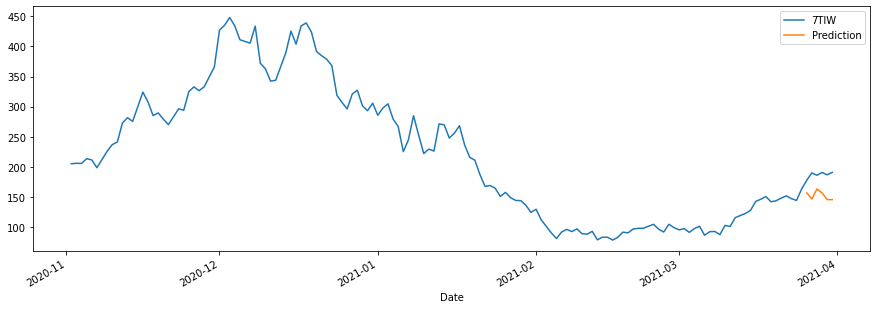

In [246]:
_ = df_all[['7TIW','Prediction']].plot(figsize=(15, 5))